# Audio-based recognition of EU euro (€)

## Part 1: Load Datasets
Load the recorded coin audio .wav files into a numpy array and create another numpy array with the class labels. Store resulting numpy arrays for data and labels as two .npy files for ease of use later on.

The labels are as follows:
- 0 - 1 cent coin
- 1 - 10 cent coin
- 2 - 2 euro coin

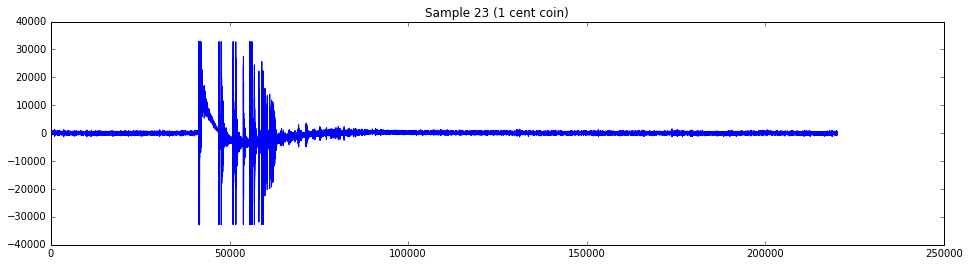

In [24]:
import glob
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

data1Cent = [wavfile.read(infile)[1] for infile in glob.glob('coins_audio_data/1_cent*.wav')]
data10Cent = [wavfile.read(infile)[1] for infile in glob.glob('coins_audio_data/10_cent*.wav')]
data2Euro = [wavfile.read(infile)[1] for infile in glob.glob('coins_audio_data/2_euro*.wav')]

# Combine into one sample set
data = np.array(data1Cent + data10Cent + data2Euro)
data = data.T
data = np.float32(data)

# Labels:
labels = np.zeros(150)
labels[50:100] += 1
labels[100:150] += 2

# Store data into numpy array
# np.save('coins_data_raw.npy', data) # >100MB file
np.save('coins_labels.npy', labels)

# Plot single sample
plt.rcParams["figure.figsize"] = [16, 4]
plt.plot(data[:, 23])
plt.title('Sample 23 (1 cent coin)')
plt.show()

## Part 2: Signal conditioning
We first normalise the data. After that we find for each sample the point of time when the coin first hits the table. This is done by searching for the first value exceeding a certain threshold value (in our case 70% of maximal value). We want all samples to be of equal length, so using the start mark we cut out a two second window from the original data. After this we send the resulting two second samples through a high-pass filter to remove the DC component that should not be present in the audio recording. Finally we store the conditioned region of interest of each recording into a .npy file.


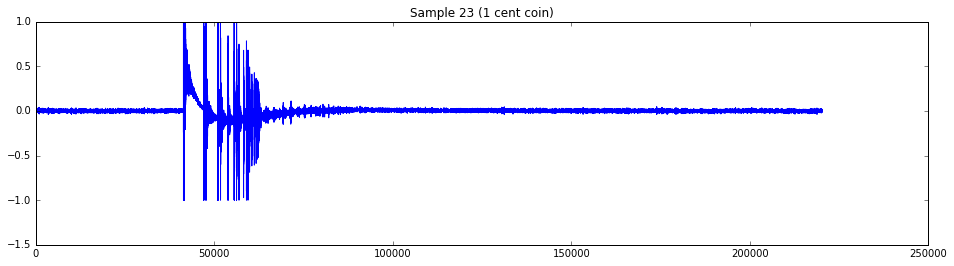

In [25]:
# Normalisation
data = np.load('coins_data_raw.npy')
data = data / data.max(axis=0)

# Plot single sample
plt.rcParams["figure.figsize"] = [16, 4]
plt.plot(data[:, 23])
plt.title('Sample 23 (1 cent coin)')
plt.show()

In [75]:
# Find the region of interest (where the coin first hits the table) for each sample
step_size = 10 # Check only every n-th sample to speed up process
threshold = 0.7
mark = np.zeros(data.shape[1], dtype=int)
for i in range(data.shape[1]): 
    for j in range(data.shape[0]/step_size):
        if(data[j*step_size, i] > threshold):
            mark[i] = j*step_size
            break

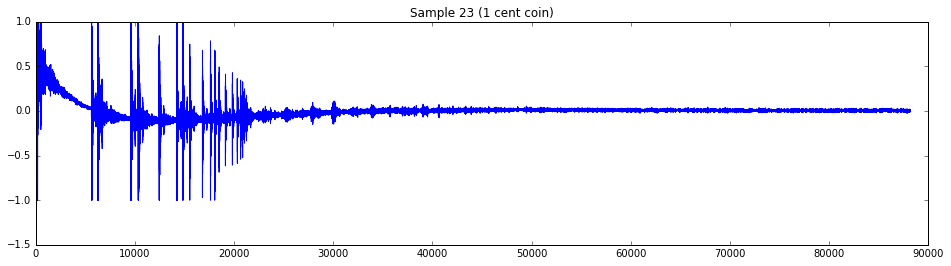

In [147]:
# CLip out a two second window starting from previously found mark for each sample
N = 88200 # Amount of samples for a two second window
data_roi = np.zeros((N, data.shape[1]))
for i, m in enumerate(mark):
    data_roi[:, i] = data[m:m+N, i]

plt.rcParams["figure.figsize"] = [16, 4]
plt.plot(data_roi[:,23])
plt.title('Sample 23 (1 cent coin)')
plt.show()

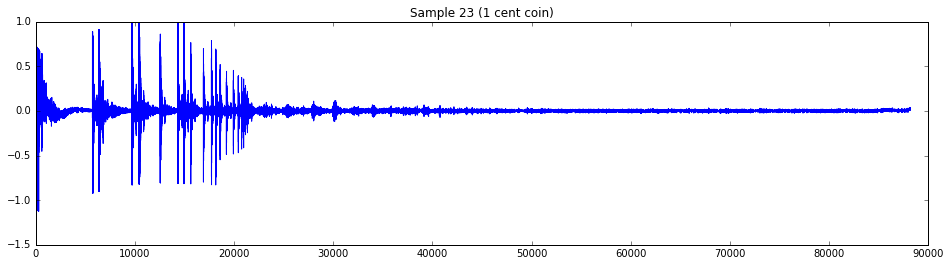

In [78]:
# Filter data, remove DC component
from scipy import signal
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


cutoff = 10 # 10 Hz cutoff frequency
fs = 44100  # sampling frequency
order = 5   # Filter order
data_roi_filtered = np.zeros((N, data.shape[1]))
for i in range(data_roi.shape[1]):
    filtered = butter_highpass_filter(data_roi[:, i], cutoff, fs, order)
    filtered = filtered / filtered.max(axis=0) 
    data_roi_filtered[:, i] = filtered    

plt.rcParams["figure.figsize"] = [16, 4]
plt.plot(data_roi_filtered[:, 23])
plt.title('Sample 23 (1 cent coin)')
plt.show()

# Store the filtered, normalised region of interest of each recording into a numpy array
# np.save('coins_data_roi.npy', data_roi_filtered)  # >100MB files

## Part 3: Feature computation
In this part we perform a FFT to get the frequency content of each sample. We use this to look for suitable features that can be used to classify the coins.

In [143]:
# Perform FFT on data
from scipy.fftpack import fft
data_roi_filtered = np.load('coins_data_roi.npy')

data_fft = [fft(data_roi_filtered[:, i]) for i in range(data_roi_filtered.shape[1])]
data_fft = np.array([data_fft[i][0:N//2] for i in range(len(data_fft))])

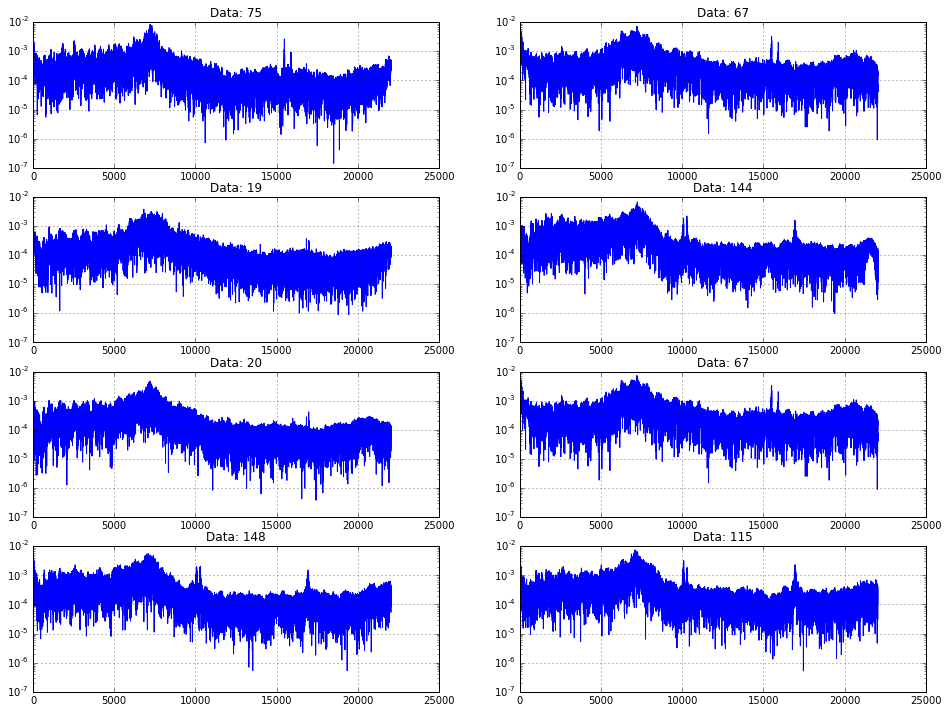

In [144]:
# Plot some frequency plots from randomly chosen samples
import random
T = 1.0 / fs
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.rcParams["figure.figsize"] = [16, 12]
randnums = [random.randint(0, 149) for i in range(8)]
f, splt = plt.subplots(4, 2)
for i, p in enumerate(randnums):
    splt[i%4, i/4].semilogy(xf, 2.0/N * np.abs(data_fft[p]))
    splt[i%4, i/4].set_title("Data: {}".format(p))
    splt[i%4, i/4].grid()
plt.show()

From the frequency plots we can see that:

- 1 cent coins (data 0-49) have no distinguishable peaks
- 10 cent coins (data 50-99) have a distinguishable double peak around 16.000 Hz
- 2 euro coins (data 100-149) have a distinguishable peak around 17.000 Hz, and a double peak around 10.500 Hz

## Part 4: Feature extraction

The characteristics listed above mean that we can cut out a window in the 15-18 KHz range and hopefully still have enough information to be able to classify the different coins as they all have different characteristics in this frequency region. 
We cut out a 3 KHz window and create several "bins" to reduce the amount of features.

In [81]:
# Extract the frequency area 15-18 KHz from each sample
l_bound = 15000*(N//2)/(fs/2)
u_bound = 18000*(N//2)/(fs/2)
data_fft_roi = data_fft[:, l_bound:u_bound]

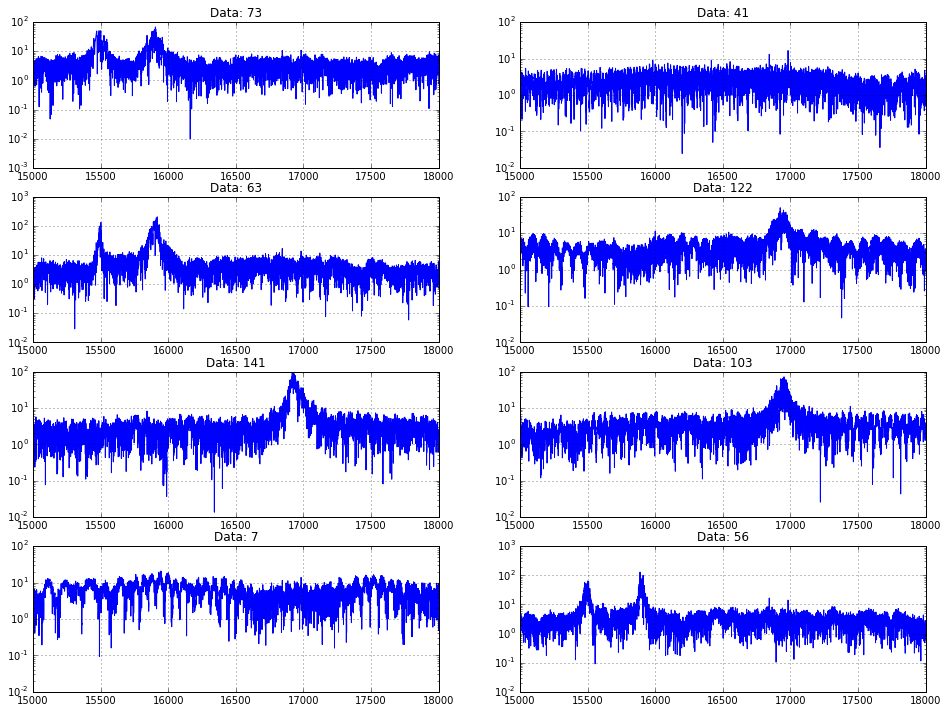

In [82]:
# Plot some frequency plots from randomly chosen samples
plt.rcParams["figure.figsize"] = [16, 12]
randnums = [random.randint(0, 149) for i in range(8)]
f, splt = plt.subplots(4, 2)
for i, p in enumerate(randnums):
    splt[i%4, i/4].semilogy(xf[l_bound:u_bound], np.abs(data_fft_roi[p]))
    splt[i%4, i/4].set_title("Data: {}".format(p))
    splt[i%4, i/4].grid()
plt.show()

In [83]:
# Create bins for frequency content
bins = 10
bin_size = float(data_fft_roi.shape[1]/(2*bins)) # in Hz
step = int((N//2)*(bin_size/(fs/2))) # Bin size in samples
data_bin = np.zeros((data_fft_roi.shape[0], (int(data_fft_roi.shape[1]/step))))
for i in range(data_fft_roi.shape[0]):
    data_bin[i] = [sum(abs(data_fft_roi[i, idx*step:(idx+1)*step-1])) for idx in range(data_fft_roi.shape[1]/step)]   

# Store features in numpy array
np.save('coins_features.npy', data_bin)

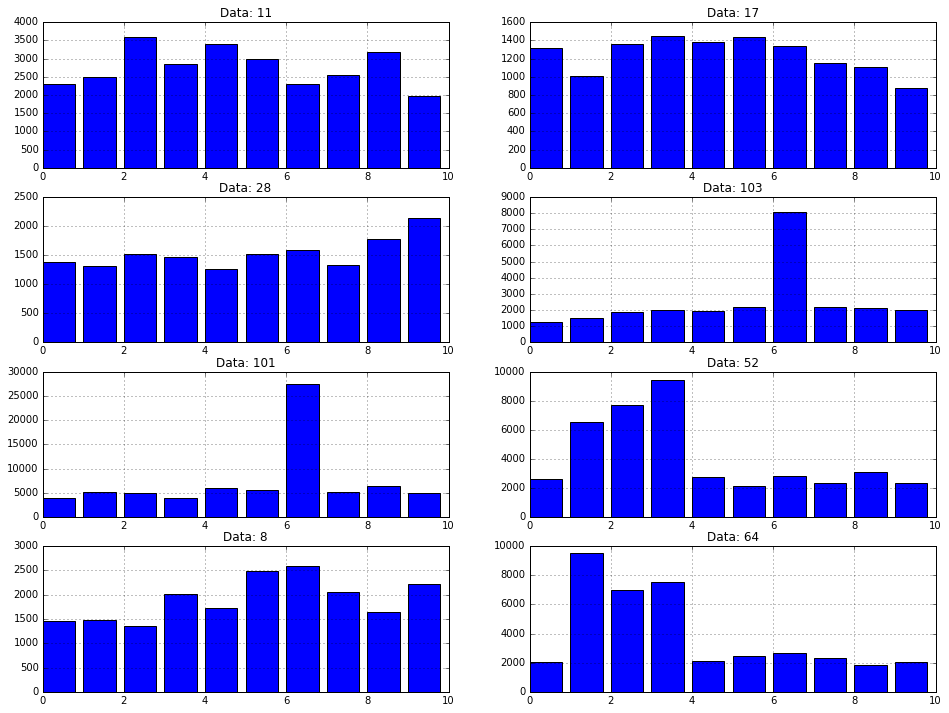

In [148]:
# Plot some bar plots from randomly chosen samples
x = np.arange(len(data_bin[1]))
plt.rcParams["figure.figsize"] = [16, 12]
randnums = [random.randint(0, 149) for i in range(8)]
f, splt = plt.subplots(4, 2)
for i, p in enumerate(randnums):
    splt[i%4, i/4].bar(x, data_bin[p])
    splt[i%4, i/4].set_title("Data: {}".format(p))
    splt[i%4, i/4].grid()
plt.show()

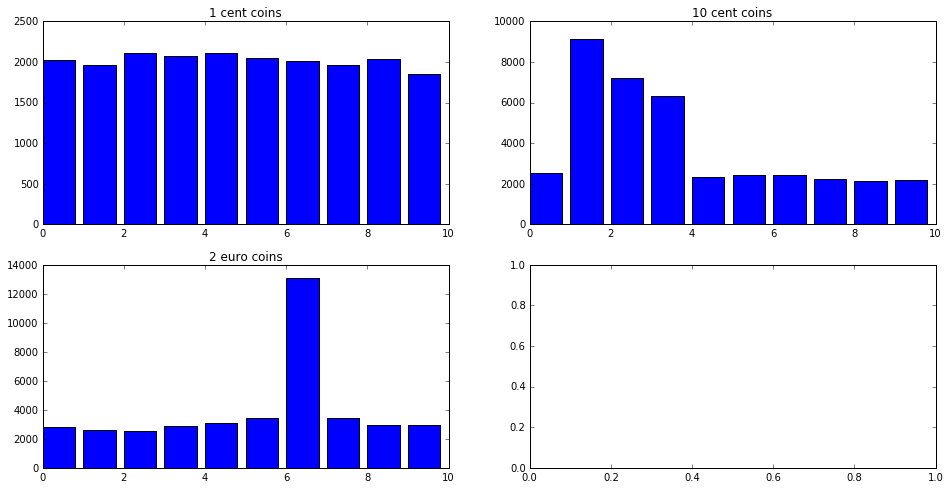

In [142]:
# Plot average value of bins for each different class
data_bin = np.load('coins_features.npy')
x = np.arange(len(data_bin[1]))
plt.rcParams["figure.figsize"] = [16, 8]
f, splt = plt.subplots(2,2)

def avg(x):
    return sum(x)/len(x)

splt[0,0].bar(x, avg(data_bin[0:49]))
splt[0,0].set_title("1 cent coins")
splt[0,1].bar(x, avg(data_bin[50:99]))
splt[0,1].set_title("10 cent coins")
splt[1,0].bar(x, avg(data_bin[100:149]))
splt[1,0].set_title("2 euro coins")
plt.show()

From the bar plots of the frequency bins 1-10 (note the different absolute value for different samples) we can see that:
- 1 cent coins (data 0-49) have roughly equally much of each bin
- 10 cent coins (data 50-99) have more of bins 2-4 than the rest, corresponding to the 15.300-16.200 Hz region
- 2 euro coins (data 100-149) have a lot more of bin 7 than the rest, corresponding to the 16.800-17.100 Hz region

So we have found that using no more than ten features we ourselves can classify the coins from visual inspection of the bar plots.

## Part 5: Dimentionality Reduction

- Principal Component Analysis (PCA) [Wikipedia link](https://en.wikipedia.org/wiki/Principal_component_analysis)
    - Transforms data into set of linearly uncorrelated variables called **principal components**
    - Each principal component explains some amount of the variance in the data in descending order, i.e. the first principal component explains the most of the variance.
    - PCA has no information on which class a sample belongs to, it only works with the data itself.
    - "*If a multivariate dataset is visualised as a set of coordinates in a high-dimensional data space (1 axis per variable), PCA can supply the user with a lower-dimensional picture, a projection of this object when viewed from its most informative viewpoint. This is done by using only the first few principal components so that the dimensionality of the transformed data is reduced.*" (From the Wikipedia page on PCA)


- Linear Discriminant Analysis (LDA) [Wikipedia link](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)
    - Tries to find a linear combination of features that separates the classes as much as possible.
    - This naturally means that LDA uses the labels of the data to perform its operation, unlike PCA which works on unlabelled data.


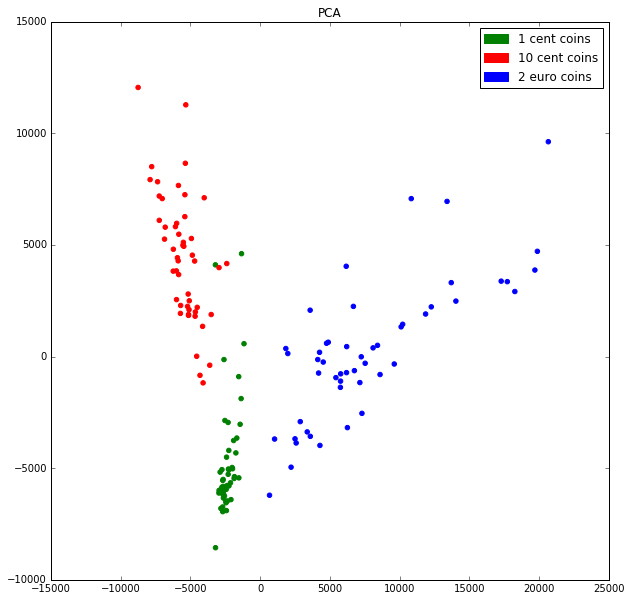

In [88]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit(data_bin)

# Visualisation
import matplotlib.patches as mpatches
colors = ['red' if int(l)==1 else 'blue' if int(l)==2 else 'green' for l in labels]
yPCA = pca.transform(data_bin)

plt.rcParams["figure.figsize"] = [10, 10]
plt.scatter(yPCA[:,0], yPCA[:,1], color=colors)
plt.title('PCA')
green_patch = mpatches.Patch(color='green', label='1 cent coins')
red_patch = mpatches.Patch(color='red', label='10 cent coins')
blue_patch = mpatches.Patch(color='blue', label='2 euro coins')
plt.legend(handles=[green_patch, red_patch, blue_patch])
plt.show()

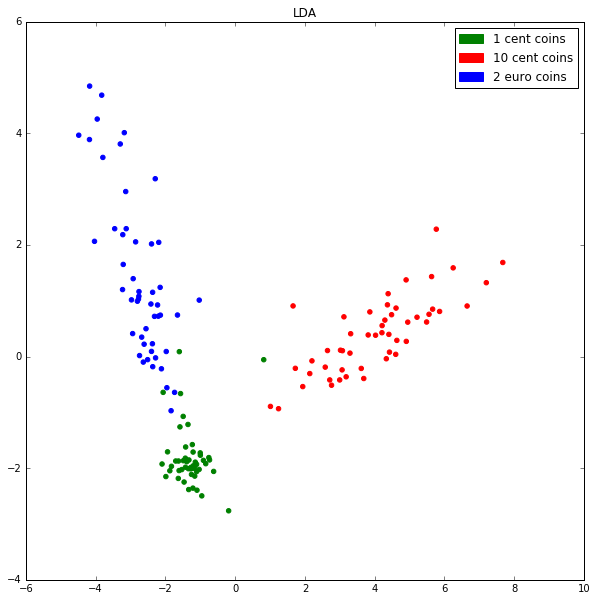

In [87]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda = lda.fit(data_bin, labels)

# Visualisation
plt.rcParams["figure.figsize"] = [10, 10]
xVis = lda.transform(data_bin)

plt.scatter(xVis[:,0], xVis[:,1], color=colors)
plt.title('LDA')
plt.legend(handles=[green_patch, red_patch, blue_patch])
plt.show()

## Part 5: Classifier training

Classifiers used:
- Linear Discriminant Analysis (LDA)
- K-nearest neighboors (KNN)


In [165]:
# Randomly split data into training and test sets. Here 80% of samples for training, and the remaining 20% for testing.
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(data_bin, labels, test_size=0.2)

In [166]:
# LDA as classifier
clf_lda = LinearDiscriminantAnalysis(n_components=2)
clf_lda = clf_lda.fit(xTrain, yTrain)

## Part 6: Classifier testing and performance evaluation

In [176]:
# LDA as classifier
from sklearn.metrics import confusion_matrix

predict = clf_lda.predict(xTest)
cmatrix = confusion_matrix(yTest, predict)

print(cmatrix)
print('LDA classifier accuracy: {}'.format(clf_lda.score(xTest, yTest)))

[[12  0  0]
 [ 0  8  0]
 [ 1  0  9]]
LDA classifier accuracy: 0.966666666667


## Part 7: Neural Network approach (from scratch)
This part is based on the code found in [Implementing a Neural Network from Scratch in Python – An Introduction](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/).<br/>
In this part we try to make use of a small neural network to classify the coins. We use the ten features (frequency bins) found earlier on as inputs to the network.


In [225]:
#================================
# CURRENTLY NOT WORKING PROPERLY!
#================================

num_examples = len(data_bin) # training set size
nn_input_dim = 10 # input layer dimensionality
nn_output_dim = 3 # output layer dimensionality
 
# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength


# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

    # Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = xTrain.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(len(xTrain)), :])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss


# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
     
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    # This is what we return at the end
    model = {}
     
    # Gradient descent. For each batch...
    delta3 = np.zeros((120, 3))
    for i in xrange(0, num_passes):
 
        # Forward propagation
        z1 = xTrain.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        for j in range(probs.shape[0]):
            sample = probs[j,:]
            label = yTrain[j]      
            if label==2:
                sample[2] -=1
            elif label==1:
                sample[1] -=1
            else:
                sample[0] -=1
            delta3[j] = sample
        
        #delta3 = probs
        
        # delta3[range(num_examples), :] -= 1
        
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(xTrain.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
 
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        #print W1
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i%1000==0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(model))     
    return model

model = build_model(3, print_loss=False)
pred_res = predict(model, xTest)

print pred_res
print yTest

## Part 8: Neural Network using Tensorflow